# Sequence-to-Sequence: Language Translation

In this assignment you will use a database of pairs of (English,French) sentences to train an RNN model to translate from English to French.

The directory ../resource/asnlib/publicdata contains two files, "small_vocab_en.txt" and "small_vocab_fr.txt". Line "n" of the first file corresponds to line "n" of the second file.

Also see data here: http://www.statmt.org/wmt14/translation-task.html

Keras resources: 
* https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html
* https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/
* https://stackoverflow.com/questions/38714959/understanding-keras-lstms/50235563#50235563

Neural Language Translation Resources:
* https://arxiv.org/abs/1703.01619
* https://www.tensorflow.org/tutorials/seq2seq

# Setup
## Imports

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
import math
import string

import matplotlib.pyplot as plt

from IPython.display import SVG

from keras.backend.tensorflow_backend import set_session
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Input, GRU, LSTM, Dense, Masking, Dropout, Embedding, Flatten, Dense
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from keras.regularizers import l1_l2
from keras.utils import to_categorical
from keras.utils.vis_utils import model_to_dot
from sklearn.model_selection import train_test_split

import numpy as np
import tensorflow as tf

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary

## Configure Tensorflow to be less aggressive about RAM utilization when it starts up

In [3]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.1  # Start with 10% of the GPU RAM
config.gpu_options.allow_growth = True                    # Dynamically grow the memory used on the GPU
sess = tf.Session(config=config)
set_session(sess)                                         # Set this TensorFlow session as the default session for Keras

In [4]:
TRAIN_TEST_SPLIT = 0.7           # % of data in training set

NUM_LSTM_NODES = 256             # Num of intermediate LSTM nodes
CONTEXT_VECTOR_SIZE = 256        # Size of context vector (num of LSTM nodes in final LSTM layer)

EMBEDDING_DIM = 100              # Embedding layer size for input words

BATCH_SIZE = 64
NUM_EPOCHS = 500

NUM_DATA_EXAMPLES = 100000         # limit memory usage while experimenting

LR = 0.01
DROPOUT = 0.3

# Text Preprocessing
These are provided so you can focus on the neural net modeling.

In [5]:
# A useful string full of characters to remove
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [6]:
def add_space_around_punctuation(s):
    result = ''
    for c in s:
        if c in string.punctuation and c != "'":  # Apostrophes are important
            result += ' %s ' % c
        else:
            result += c
    return result

def clean_sentence(s):
    s = s.strip()
    s = s.lower()
    s = add_space_around_punctuation(s)
    return s

### Functions to get words from sentences

In [7]:
def get_words_from_sentence(s, add_start_symbol=False, add_end_symbol=False, reverse=False):
    words = list(filter(None, s.split(' ')))
    if reverse:
        words = words[::-1]
    if add_start_symbol:
        words = ['<S>'] + words
    if add_end_symbol:
        words.append('</S>')
    return words

def get_word_list_from_sentence_string(s, add_start_symbol=False, add_end_symbol=False, reverse=False):
    return get_words_from_sentence(clean_sentence(s), add_start_symbol, add_end_symbol, reverse)    
    
def get_sentences(path, filename, add_start_symbol=False, add_end_symbol=False, reverse=False):
    with open(os.path.join(path, filename), 'r') as f:
        lines = f.readlines()
        return [get_word_list_from_sentence_string(s, add_start_symbol, add_end_symbol, reverse) 
                for s in lines]

def get_word_set(sentences):
    words = set()
    for s in sentences:
        for word in s:
            words.add(word)
    return words

## Read the data and build useful data structures, such as a list of sentences and lists of words.

In [8]:
# Store the input sentences (English) in s1
# Store the target senteces (French) in s2

# Consider reversing the input sentences to improve trianing. - TODO: Try this later
# Add start and stop symbols for the decoder.
PATH = '../resource/asnlib/publicdata'
s1 = get_sentences(PATH, 'small_vocab_en.txt', add_start_symbol=True, add_end_symbol=True, reverse=False)
s2 = get_sentences(PATH, 'small_vocab_fr.txt', add_start_symbol=True, add_end_symbol=True, reverse=False)

Let's check out an example of an English and French sentence.

In [9]:
print(s1[0])
print(s2[0])

['<S>', 'new', 'jersey', 'is', 'sometimes', 'quiet', 'during', 'autumn', ',', 'and', 'it', 'is', 'snowy', 'in', 'april', '.', '</S>']
['<S>', 'new', 'jersey', 'est', 'parfois', 'calme', 'pendant', "l'", 'automne', ',', 'et', 'il', 'est', 'neigeux', 'en', 'avril', '.', '</S>']


In [10]:
# Look at size of entire data set
print(len(s1))

137860


Let's go ahead and use the entire data set, so we'll comment out the code below.

In [11]:
# Restruct to a subset of the data
# s1 = s1[:NUM_DATA_EXAMPLES]
# s2 = s2[:NUM_DATA_EXAMPLES]

In [12]:
# Show a sample sentence pair.
' '.join(s1[0]), ' '.join(s2[0])

('<S> new jersey is sometimes quiet during autumn , and it is snowy in april . </S>',
 "<S> new jersey est parfois calme pendant l' automne , et il est neigeux en avril . </S>")

In [13]:
# Create two lists, w1 and w2, which hold the set of all words that show up in s1 and s2.
w1 = get_word_set(s1)
w2 = get_word_set(s2)

The code below shows the number of unique English and French words in all sentences.

In [14]:
# Print word list lengths
print(len(w1))
print(len(w2))

204
350


### Utilities for mapping words to integers

In [15]:
def get_word_to_index_dict(words):
    return {w: i+1 for i,w in enumerate(words)}  # use i+1 to reserve 0 for the mask index
def reverse_dict(d):
    return {v: k for k,v in d.items()}

In [16]:
word_to_index1 = get_word_to_index_dict(w1)
word_to_index2 = get_word_to_index_dict(w2)
index_to_word1 = reverse_dict(word_to_index1)
index_to_word2 = reverse_dict(word_to_index2)
index_to_word1[0] = '<MASK>'
index_to_word2[0] = '<MASK>'

In [17]:
def sentence_to_indices(s, word_to_index):
    """Input s is a sentence string. word_to_index is a dict mapping words to indices.
    
    This function should convert a sentence to a list of indices, such as [5, 2, 17, 3], and return the list."""
    return [word_to_index[w] for w in s]

In [18]:
def indices_to_sentence(indices, index_to_word):
    """indices is a list of word indices. word_to_index is a dict mapping indices to words.
    
    This function should convert the indices list, such as [5, 2, 17, 3], to a list of word strings, and 
    return the list."""
    return [index_to_word[i] for i in indices]

In [19]:
# Test the functions.
x = sentence_to_indices(get_word_list_from_sentence_string('vous aimez raisins.', add_start_symbol=True, reverse=False), word_to_index2)
x

[214, 211, 7, 72, 192]

In [20]:
# Translate back to original sentence
indices_to_sentence(x, index_to_word2)

['<S>', 'vous', 'aimez', 'raisins', '.']

In [21]:
# Record the number of words in the input and output data, respectively.
num_words_X = len(w1) + 1  # add 1 to reserve 0 for mask
num_words_y = len(w2) + 1  # add 1 to reserve 0 for mask
num_words_X, num_words_y

(205, 351)

In [22]:
# Convert the input sentences in s1 to a list of sentences each represented as a list of integers.
# For example, the output list might look like [[5, 2, 17, 3], [1, 9, 85, 3, 22, 9], ...]
# Do the same for the output sentences.
inputs_as_indices = [sentence_to_indices(s, word_to_index1) for s in s1]
outputs_as_indices = [sentence_to_indices(s, word_to_index2) for s in s2]

In [23]:
# Now pad the input and output index sequences with a filler (index 0) so that all sequences for each LSTM have the 
# same length. Use the keras function pad_sequences to do this easily.
# Hint: For the inputs, padding should be on the left, like so: [[0, 0, 5, 2, 17, 3], ...]
#       For the outputs, padding should be on the right, like so: [[9, 7, 5, 4, 0, 0, 0], ...]
inputs = pad_sequences(inputs_as_indices, padding='pre', value=0)
outputs = pad_sequences(outputs_as_indices, padding='post', value=0)

The variables below store the longest English and French sentences in the data set. Note that the 'pad_sequences' function forces all sentences to be the maximum length.

In [24]:
# compute the maximum sequence length of the inputs and outputs, just to see how they look.
max_seq_len_X = len(inputs[0])
max_seq_len_y = len(outputs[0])
max_seq_len_X, max_seq_len_y

(19, 26)

In [25]:
# Just for convenience: define some more expressive variable names
max_input_seq_len = max_seq_len_X
max_output_seq_len = max_seq_len_y
num_input_words = num_words_X
num_output_words = num_words_y

In [26]:
# Create train and test sets.
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, 
                                                    test_size=1 - TRAIN_TEST_SPLIT,
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((96501, 19), (41359, 19), (96501, 26), (41359, 26))

In [27]:
y_train.shape

(96501, 26)

Using the full data set leads to memory errors related to the one-hot encoding procedure. The error is related to initializing the numpy array of zeros for the target data. For this reason, we'll switch the loss function to 'sparse_categorical_crossentropy', which will let us use the response data directly without the need to one-hot encode.

In [28]:
# We need to make a one-hot-encoded version of the outputs ourselves for use in the loss function. 
# The inputs get this for free via use of Embedding layers in Keras.
#
# Use the keras function to_categorical.
# y_train_one_hot = to_categorical(y_train, num_classes=num_words_y)
# y_test_one_hot = to_categorical(y_test, num_classes=num_words_y)

## Create Model

Now we need to write code to build the SeqToSeq model. **Important**: In Keras we have to use the "functional API" in order to access the LSTM internal state that we use as the "context vector" or "encoding" of a sentence. We also need to store hooks into the model to be able to run the translator on new sentences after training.

This code will create variables representing the entire SeqToSeq model (for use in training), as well as the individual encoder segment and decoder segment of the model, for use in inference.

### Encoder

We will implement the following architecture for the encoder section of the seq2se1 model:
    
1. Encoder input (encoder_inputs): Input layer, shape (max_seq_len_X,). For convenience, name the layer: name='encoder_input'
2. Masking layer (encoder_masking): doesn't change shape. Ignores leading mask value ("0"s) in short sequences.
3. Embedding layer (encoder_embedding): output shape (max_seq_len_X, EMBEDDING_DIM)
4. LSTM layer: size is NUM_LSTM_NODES. uses dropout at rate given by DROPOUT.

Hint: Be sure to set the "return_sequences" and "return_state" parameters appropriately in the LSTM for the encoder.

In [30]:
# Build RNN model.
encoder_inputs = Input(shape=(max_input_seq_len,), name='encoder_input')
encoder_masking = Masking(mask_value=0)(encoder_inputs)
encoder_embedding = Embedding(num_words_X+1, EMBEDDING_DIM)(encoder_masking)
encoder_outputs, state_h, state_c = LSTM(NUM_LSTM_NODES, dropout=DROPOUT, return_sequences=False, return_state=True, name='encoder_lstm_1')(encoder_embedding) 
# Discard `encoder_outputs` and only keep the states. We don't use the outputs in the encoder.
# Recall that the LSTM has two states we have to keep track of: c and h.
encoder_states = [state_h, state_c]

### Decoder

# The decoder should have the following architecture:
    
1. Decoder input (decoder_input): shape (None,)
2. Masking layer (decoder_masking), as above.
3. Embedding layer (decoder_embedding): output shape (max_seq_len_y, EMBEDDING_DIM)
4. LSTM layer (decoder_lstm), as above. However, keep a function around to easy recreate the LSTM layer later on, during generation.
6. Dense layer with softmax activation (decoder_output): output shape (num_output_words,)

Hint: Be sure to set the "return_sequences" and "return_state" parameters appropriately in the LSTM for the encoder.

In [31]:
# Decoder section
# Set up the decoder, using encoder_states as initial state.
decoder_inputs = Input(shape=(None,), name='decoder_input')
decoder_inputs_masking = Masking(mask_value=0)(decoder_inputs)
decoder_inputs_embedded = Embedding(num_words_y+1, EMBEDDING_DIM)(decoder_inputs_masking)
decoder_lstm = LSTM(NUM_LSTM_NODES, dropout=DROPOUT, return_sequences=True, return_state=True) # Just define an LSTM here, but don't pass in the previous layer variable yet.

z, _, _ = decoder_lstm(decoder_inputs_embedded, initial_state=encoder_states) # Pass in the context vector using the "initial_state" param

decoder_dense = Dense(num_words_y, activation='softmax') # Like LSTM above: define function for later use
decoder_outputs = decoder_dense(z)

### Put it all together into one model, and visualize

In [32]:
# Define the complete seq2seq model.
# This will take encoder_input_data & decoder_input_data as inputs and learn to output the decoder_target_data.
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 19)           0                                            
__________________________________________________________________________________________________
decoder_input (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
masking_1 (Masking)             (None, 19)           0           encoder_input[0][0]              
__________________________________________________________________________________________________
masking_2 (Masking)             (None, None)         0           decoder_input[0][0]              
__________________________________________________________________________________________________
embedding_

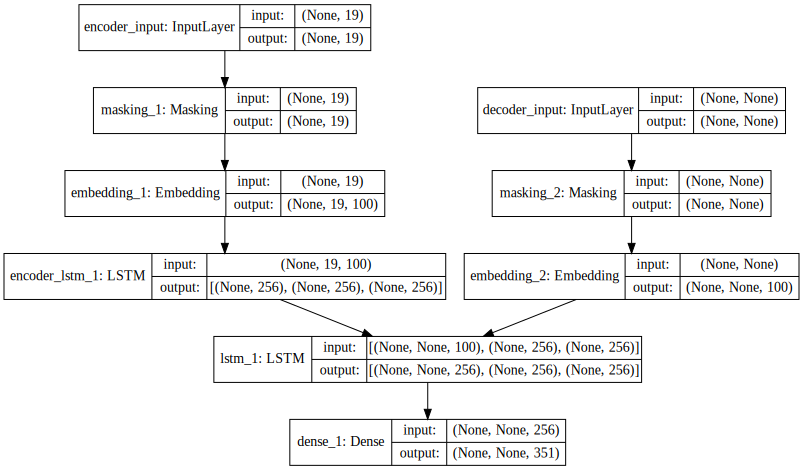

In [33]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## Prepare train/test data.

In [34]:
encoder_input_data = X_train
decoder_input_data = y_train

As mentioned above, we're not using the one-hot encoded based process to avoid memory errors. The target data is formed in nearly the same manner, however the arrays are smaller.

In [35]:
decoder_target_data = np.zeros(y_train.shape)
decoder_target_data[:,:-1] = y_train[:,1:]
decoder_target_data_test = np.zeros(y_test.shape)
decoder_target_data_test[:,:-1] = y_test[:,1:]

We can see that the decoder target data is still ahead of the training data by a single timestep, as intended.

In [36]:
print(y_train[0])

[214  95 160 322 216 259 129 110 305 166 322 227 121 234  95 236 192 176
   0   0   0   0   0   0   0   0]


In [37]:
print(decoder_target_data[0])

[ 95. 160. 322. 216. 259. 129. 110. 305. 166. 322. 227. 121. 234.  95.
 236. 192. 176.   0.   0.   0.   0.   0.   0.   0.   0.   0.]


Because the model is expecting the decoder target data to have three dimensions, we have to perform the reshape procedure below.

In [38]:
decoder_target_data = np.reshape(decoder_target_data,(decoder_target_data.shape[0],decoder_target_data.shape[1],1))
decoder_target_data_test = np.reshape(decoder_target_data_test,(decoder_target_data_test.shape[0],decoder_target_data_test.shape[1],1))

In [39]:
# decoder_target_data will be ahead by one timestep
# and will not include the start token.
# decoder_target_data = np.zeros(y_train_one_hot.shape)
# decoder_target_data[:,:-1] = y_train_one_hot[:,1:,:]

In [40]:
# decoder_target_data_test = np.zeros(y_test_one_hot.shape)
# decoder_target_data_test[:,:-1] = y_test_one_hot[:,1:,:]

As noted above, we're changing the loss function to 'sparse_categorical_crossentropy'.

In [41]:
optimizer = Adam(lr=.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')

In [42]:
lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1, mode='auto', 
                                cooldown=0, min_lr=0)

In [43]:
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

In [44]:
# Run training
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=BATCH_SIZE,
          epochs=NUM_EPOCHS,
          validation_data=([X_test, y_test], decoder_target_data_test),
          callbacks=[lr_callback, early_stopping_callback])

Train on 96501 samples, validate on 41359 samples
Epoch 1/500
96501/96501 [==============================] - 409s 4ms/step - loss: 0.8326 - val_loss: 0.4315
Epoch 2/500
96501/96501 [==============================] - 413s 4ms/step - loss: 0.3145 - val_loss: 0.1654
Epoch 3/500
96501/96501 [==============================] - 419s 4ms/step - loss: 0.0951 - val_loss: 0.0444
Epoch 4/500
96501/96501 [==============================] - 424s 4ms/step - loss: 0.0384 - val_loss: 0.0271
Epoch 5/500
96501/96501 [==============================] - 422s 4ms/step - loss: 0.0260 - val_loss: 0.0215
Epoch 6/500
96501/96501 [==============================] - 429s 4ms/step - loss: 0.0198 - val_loss: 0.0169
Epoch 7/500
96501/96501 [==============================] - 433s 4ms/step - loss: 0.0160 - val_loss: 0.0145
Epoch 8/500
96501/96501 [==============================] - 856s 9ms/step - loss: 0.0134 - val_loss: 0.0129
Epoch 9/500
96501/96501 [==============================] - 785s 8ms/step - loss: 0.0117 - val_

# Inference

We have trained a model, but how do we use it to actually translate sentences? We have to do more work ourselves here than with a non-recurrent neural net, so we'll write a function to help out. Here are the steps:

1. **Encode**:
    1. Run the entire input sentence through the encoder part of the model.
    1. Write down the "context vector" -- this is the state of the last LSTM encoder layer.<br><br>

2. **Decode in a loop**:
    1. Seed the decoder LSTM with the context vector.
    1. Run a *single step* of the decoder with the input "`<S>`" (the start symbol).
    1. Store the output. This is a word of the translation!
    1. Return to step 2B, but feed in the word from step 2C as the new input. Repeat until the decoder returns "`</S>`" (the end symbol).

In [45]:
# Define a version of our model for use in sampling (as opposed to training).
encoder_model = Model(encoder_inputs, encoder_states)
encoder_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 19)                0         
_________________________________________________________________
masking_1 (Masking)          (None, 19)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 19, 100)           20600     
_________________________________________________________________
encoder_lstm_1 (LSTM)        [(None, 256), (None, 256) 365568    
Total params: 386,168
Trainable params: 386,168
Non-trainable params: 0
_________________________________________________________________


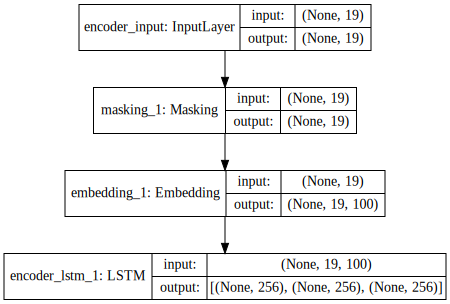

In [46]:
SVG(model_to_dot(encoder_model, show_shapes=True).create(prog='dot', format='svg'))

In [47]:
# Build the decoder.
decoder_state_input_h = Input(shape=(NUM_LSTM_NODES,))
decoder_state_input_c = Input(shape=(NUM_LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs_embedded, initial_state=decoder_states_inputs)

decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs] + decoder_states)
decoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
masking_2 (Masking)             (None, None)         0           decoder_input[0][0]              
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 100)    35200       masking_2[0][0]                  
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 256)          0                                            
__________________________________________________________________________________________________
input_2 (I

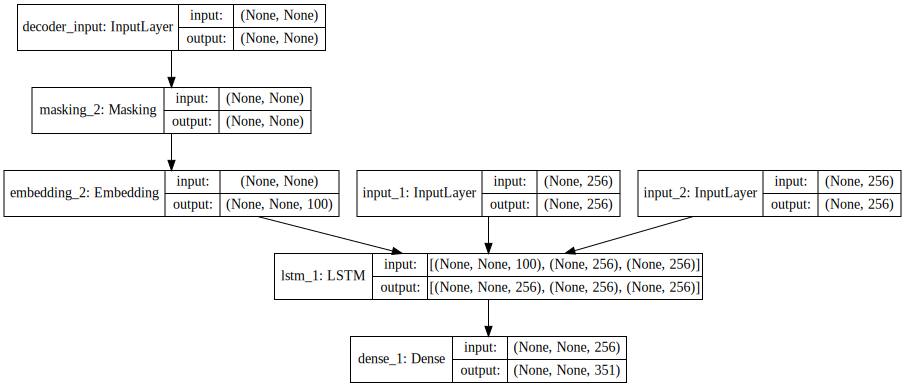

In [48]:
SVG(model_to_dot(decoder_model, show_shapes=True).create(prog='dot', format='svg'))

In [49]:
def translate_sequence(input_seq):
    # Encode the input as state vectors.
    h, c = encoder_model.predict(np.reshape(input_seq,(1,max_input_seq_len)))
    states_value = [h, c]
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))
    # Populate the first word of target sequence with the start symbol '<S>'.
    target_seq[0, 0] = word_to_index2['<S>']
    
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    decoded_sentence = ''
    stop_condition = False
    step = 0
    while not stop_condition:
        # Use the decoder to get the output token vector and the h and c vectors
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        
        # Find the largest value in the probability output vector, and use that index as your output word
        # at this time step.
        sampled_token_index = np.argmax(output_tokens)
        sampled_word = index_to_word2[sampled_token_index]
        
        # Add the word to the output sentence string
        decoded_sentence += sampled_word + ' '
        
        # Stopping condition: either hit max length or find the stop token '</S>'.
        step += 1
        if sampled_word == '</S>' or step == max_seq_len_y:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

# Test your network: feed in 10 sentences and show the results.

In [50]:
num_to_test = 10
for i in range(num_to_test):
    print('Testing sentence %i of %i' % (i+1,num_to_test))
    # Print an input sentence
    english = indices_to_sentence(X_test[i], index_to_word1)
    print(' '.join(english))
    # Translate it and print the output sentence
    translated = translate_sequence(X_test[i])
    print(translated)
    actual = indices_to_sentence(y_test[i], index_to_word2)
    print('')

Testing sentence 1 of 10
<MASK> <MASK> <S> china is usually busy during september , but it is sometimes cold in spring . </S>
chine est généralement occupé en septembre , mais il est parfois froid au printemps . </S> 

Testing sentence 2 of 10
<MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <S> he dislikes pears and peaches . </S>
il aime pas les poires et les pêches . </S> 

Testing sentence 3 of 10
<MASK> <S> the united states is sometimes rainy during january , but it is mild in may . </S>
les états - unis est parfois pluvieux en janvier , mais il est doux en mai . </S> 

Testing sentence 4 of 10
<MASK> <MASK> <MASK> <S> california is mild during march , but it is sometimes rainy in october . </S>
california est doux au mois de mars , mais il est parfois pluvieux en octobre . </S> 

Testing sentence 5 of 10
<MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <S> he dislikes mangoes and strawberries . </S>
il n'aime les mangues et

### Question: How well do you think the model did? Discuss any problems you ran into.

Based on the 10 sentences fed into the model from the test set, the model appears to be doing a very good job of translating the sentences (I speak some French, and the sentences appear to be mostly correct). This is a promising result, as these are all setences that the model has never seen.

The biggest problem I ran into was the fact that I set the 'input_length' argument in the embedding layers. This assumes all input sequences are the same length, which is true during training, and so the model trained successfully. However, during inference the sentences are fed to the decoder a single word at a time, and this led to errors at first (the dense layer was always expecting a 24x310 array, but I was feeding it a 1x310 array). Removing the 'input_length' argument fixed this issue.

# Evaluate model accuracy

### Compute the accuracy of the model on the test set.
In a detailed study we would calculate the "BLEU" score for the translation task.
For this assignment, we'll keep things simple. Just calculate an all-or-nothing accuracy score on each translated sentence. If all the words appear in the output, in the correct order, without extra words, the score on that example is 1. Otherwise 0. Compute the accuracy over all examples in the test set. You may ignore punctuation (commas) and `<S>` and `</S>` symbols.

In [51]:
num_correct = 0
mistranslated = []
print('Translating %i test sentences' % len(X_test))
for i in range(len(X_test)):
    # Print progress
    if (i+1) % 5000 == 0:
        print('%2.0f%% complete...' % (i/len(X_test) * 100))
    # Translate sentence
    translated = translate_sequence(X_test[i])
    # Get actual sentence from test response
    actual = indices_to_sentence(y_test[i], index_to_word2)
    # Remove punctuation + start and stop tokens (plus mask token for actual sentence)
    translated_clean = [s for s in translated.split() if s not in ['<S>','</S>',',']]
    actual_clean = [s for s in actual if s not in ['<S>','</S>',',','<MASK>']]
    # If all entries are equal, increment counter.
    # Otherwise, add tuple of sentences to mistranslated array for further review
    if translated_clean == actual_clean:
        num_correct += 1
    else:
        mistranslated.append((translated_clean, actual_clean))

Translating 41359 test sentences
12% complete...
24% complete...
36% complete...
48% complete...
60% complete...
73% complete...
85% complete...
97% complete...


In [52]:
# Calculate test accuracy
test_accuracy = num_correct/len(X_test) * 100
print('%i out of %i sentences correctly translated' % (num_correct,len(X_test)))
print('Test set accuracy: %4.2f%%' % test_accuracy)

39919 out of 41359 sentences correctly translated
Test set accuracy: 96.52%


## Report the accuracy value you obtained.

The highest test set accuracy obtained was 96.52%, and this is using the entire sample set (nearly 140,000 sentence pairs). Also, the setences were processed in a forward sequence (from the beginning of each sentence to the end, as they would be read). Several trials were done with the sentences in reverse order (using a subset of the data) and it did not appear to have a significant effect on the accuracy of the network.

Let's take a look at a random sampling of the mistranslated sentences to see how far off the model was.

In [53]:
# Grab 5 random mistranslations
ind = np.random.choice(list(range(len(mistranslated))), size=5)
for i in ind:
    print('Result  : %s' % ' '.join(mistranslated[i][0]))
    print('Expected: %s' % ' '.join(mistranslated[i][1]))
    print('')

Result  : la france est parfois agréable au cours de l' automne et il est jamais froid en été .
Expected: la france est parfois agréable en automne et il est jamais froid en été .

Result  : l' inde est généralement froid au mois de mars mais il est généralement enneigée en juillet .
Expected: l' inde est généralement froid en mars mais il est généralement enneigée en juillet .

Result  : ils prévoient de visiter la californie l' automne prochain .
Expected: ils ont l' intention de visiter la californie l' automne prochain .

Result  : new jersey est agréable en hiver mais jamais de neige en décembre .
Expected: new jersey est agréable pendant l' hiver mais jamais de neige en décembre .

Result  : ils ont l' intention de visiter la france en mai prochain .
Expected: ils prévoient de visiter la france en mai prochain .



In each case, the majority of the sentence has been translated correctly, only a word or two is incorrect. 

## Conceptual Overview

The structure of the network contains two parts, one for training and one for inference. Both parts consist of a separate encoder and decoder. For the training portion, English sentences, represented by pre-padded lists of indices corresponding to words in a dictionary, are fed to an embedding layer in the encoder. The embedded word vectors are passed to an LSTM layer in which the internal and long term states (denoted h and c, respectively), are retained. The output from this layer is discarded. At the same time, French sentences, represented by post-padded lists of indices corresponding to words in a dictionary, are fed to an embedding layer in the decoder. The embedded word vectors are passed to an LSTM layer in which the initial state is the state vector returned by the encoder. The output of this layer is passed to a dense layer, where a prediction of the next word in the translated sentence is returned using a softmax activation.

The purpose of network is to translate an English sentence to the equivalent sentence in French. The network training process uses what is known as 'teacher forcing', where the model is forced to learn the target output offset by one time step into the future. In other words, during training, rather than being fed the output from the previous timestep (as is typical with RNNs), the output is the 'ideal' output, which is the correct next word in the sentence. This helps prevent mistakes made early on from propagating long term.

So far, only the training process has been described. What about when a sentence is going to be translated? Here, a separate network is built using specific parts of the training network. The encoder uses the same input layer and encoder states as the training encoder. The decoder is slightly more complicated. It consists of an LSTM using the input layer from the training decoder and an initial state that will be set to the internal and long term states from an LSTM output. The output of this LSTM layer is fed to a dense layer that predicts the next word in the translated French sentence using a softmax activation as in the training process.

The actual translation process occurs as follows: